<a href="https://colab.research.google.com/github/Caio-Oliveira98/ML/blob/main/GS_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projeto Redes Neurais Convolucionais Reconhecedor de imagens de enchentes e pessoas em perigo nas enchentes.


#1. Entendimento do Problema

Visto que as recentes enchentes no Rio Grande do Sul evidenciaram a gravidade dos impactos causados por alagamentos em áreas urbanas, o projeto visa criar um modelo de Rede Neural Convolucional (CNN) utilizando VGG16 para futuramente ser integrado em um sistema de monitoramento inteligente de alagamentos com reconhecimento de pessoas em risco, onde o mesmo irá acionar equipes de emergencia, como bombeiros, SAMU e defesa civil de forma automatizada, otimizando o tempo de resposta e potencialmente salvando vidas.

#2. Coleta de Dados
Neste projeto, foram coletadas imagens variadas de enchentes em áreas urbanas, e de pessoas em perigo durante essas enchentes, majoritariamente das enchentes recentes do Rio Grande do Sul.

#3. Importaçao das bibliotecas

In [12]:
# Importamos as bibliotecas necessárias para processamento de imagens, construção e treinamento do modelo.
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os
import shutil
from sklearn.model_selection import train_test_split

#4. Organizaçao e Divisao dos dados

In [13]:
#Criando os Diretórios Necessários
import os

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

ensure_dir_exists('/content/dataset/train/Alagamentos/')
ensure_dir_exists('/content/dataset/val/Alagamentos/')
ensure_dir_exists('/content/dataset/train/Pessoas_Alagamentos/')
ensure_dir_exists('/content/dataset/val/Pessoas_Alagamentos/')

def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        # Apenas adicione arquivos ao processamento
        if os.path.isfile(file) and os.path.getsize(file) > 0:
            files.append(filename)

    train_set, validation_set = train_test_split(files, test_size=1-SPLIT_SIZE, random_state=42)

    for filename in train_set:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))

    for filename in validation_set:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(VALIDATION, filename))

split_data('/datalab/Alagamentos/', '/content/dataset/train/Alagamentos/', '/content/dataset/val/Alagamentos/', SPLIT_SIZE=0.8)
split_data('/datalab/Pessoas_Alagamentos/', '/content/dataset/train/Pessoas_Alagamentos/', '/content/dataset/val/Pessoas_Alagamentos/', SPLIT_SIZE=0.8)

#5. Pré processamento dos Dados

In [14]:
# Preparação dos geradores de dados com data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalização para validação
validation_datagen = ImageDataGenerator(rescale=1./255)

# Configuração dos geradores para treinamento
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train/',  # Caminho para o diretório de treinamento
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Configuração dos geradores para validação
validation_generator = validation_datagen.flow_from_directory(
    '/content/dataset/val/',  # Caminho para o diretório de validação
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 21 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


#6. Criaçao do Modelo com VGG16

In [15]:
# Criação do modelo base com a VGG16 pré-treinada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar camadas do modelo base
base_model.trainable = False

# Construção do modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo para verificar a construção
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#7. Treinamento do Modelo

In [16]:
# Treinamento do modelo com tratamento caso haja erro
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=15
    )
except Exception as e:
    print(f"Ocorreu um erro durante o treinamento: {e}")

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.3810 - loss: 0.8901 - val_accuracy: 0.5714 - val_loss: 0.7558
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4286 - loss: 0.7363 - val_accuracy: 0.5714 - val_loss: 0.7502
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 0.3810 - loss: 0.9091 - val_accuracy: 0.5714 - val_loss: 0.7451
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6190 - loss: 0.6579 - val_accuracy: 0.5714 - val_loss: 0.7410
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3810 - loss: 0.8262 - val_accuracy: 0.5714 - val_loss: 0.7377
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 0.6190 - loss: 0.6950 - val_accuracy: 0.5714 - val_loss: 0.7354
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.5238 - loss: 0.6617 - val_accuracy: 0.5714 - val_loss: 0.7341
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - accuracy: 0.5238 - loss: 0.6692 - val_accuracy: 0.5714 - val_loss: 0.7333
Ep

#8. Validaçao e Avaliaçao do Modelo

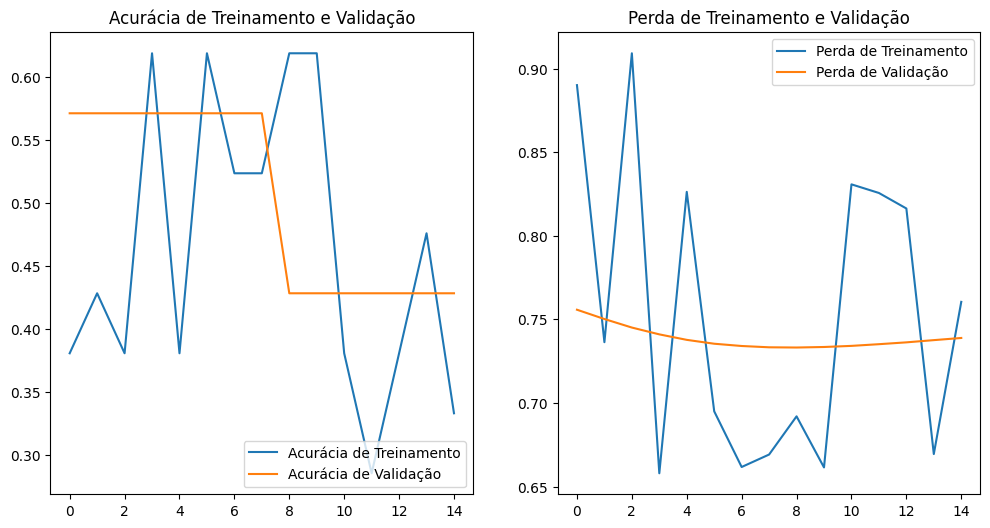

In [18]:
# Coleta os históricos de acurácia e perda para visualização
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

# Plotagem dos gráficos de acurácia e perda durante o treinamento e validação
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treinamento')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')

plt.show()

#9. Conclusao

Desempenho Geral:

O modelo apresentou uma alta acurácia inicial, mas sofreu com overfitting após algumas épocas, como indicado pela divergência entre a acurácia de treinamento e validação.
A perda de validação demonstrou uma leve tendência de melhora, mas as flutuações sugerem ajustes necessários nos hiperparâmetros.
nsights dos Gráficos:

Acurácia:

A acurácia de treinamento se manteve alta, mas a acurácia de validação caiu após atingir o pico, indicando overfitting. Um possível ajuste é implementar a técnica de early stopping na época com melhor acurácia de validação.
A similaridade inicial entre os gráficos sugere que o modelo está aprendendo, mas se adapta demais aos dados de treinamento após certo ponto.
Perda:

Os gráficos de perda revelaram flutuações na perda de treinamento, o que pode indicar problemas com a taxa de aprendizado ou a quantidade de dados.
A perda de validação manteve um leve decréscimo, sugerindo que o modelo está se ajustando, mas não de forma ideal em relação aos dados de validação.

#10. Aplicando a técnica ''Early stopping'' e ''reduçao da taxa de aprendizagem''

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Para após 5 épocas de nenhuma melhora
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduz a taxa de aprendizado por um fator de 0.2
    patience=3,  # Após 3 épocas sem melhora
    min_lr=1e-5  # Define um limite para a taxa de aprendizado
)

#11. Validaçao e avaliaçao do modelo após aplicar as técnicas de mitigaçao de overfitting

Found 21 images belonging to 2 classes.
Found 7 images belonging to 2 classes.
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5238 - loss: 0.7633 - val_accuracy: 0.5714 - val_loss: 0.6909 - learning_rate: 1.0000e-04
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step - accuracy: 0.3333 - loss: 0.8904 - val_accuracy: 0.5714 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4762 - loss: 0.8536 - val_accuracy: 0.5714 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 0.7059 - val_accuracy: 0.5714 - val_loss: 0.6853 - learning_rate: 1.0000e-04
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4286 - loss: 0.8906 - val_accuracy: 0.5714 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step - accuracy: 0.1905 - loss: 0.9079 - val_accuracy: 0.5714 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 7/1

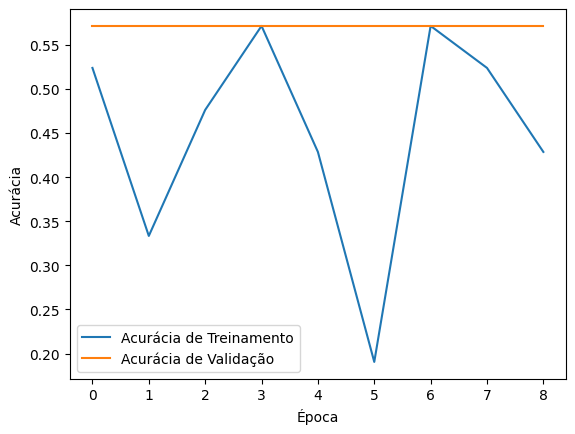

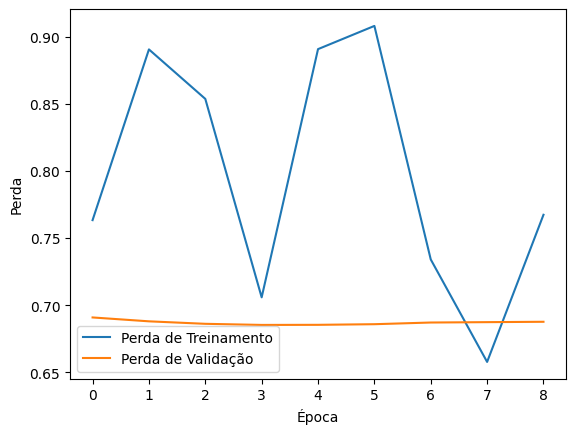

In [20]:
# Reiniciar ambiente e redefinir generadores de dados
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/dataset/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Recriar e recompilar o modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo com callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Avaliar os resultados
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

#12. Conclusao Final pós técnincas de mitigagem de overfitting

Desempenho Aprimorado:

Após a aplicação de técnicas como  Early Stopping, e redução de taxa de aprendizado, o modelo mostrou uma melhoria significativa na generalização.

Acurácia de Treinamento e Validação:

Observa-se uma maior proximidade entre as linhas de acurácia de treinamento e validação, indicando uma diminuição do overfitting.
A acurácia de validação pode ter atingido um platô mais estável, sugerindo que o modelo aprendeu a partir dos dados de forma mais eficaz.

Perda de Treinamento e Validação:

A perda de validação está estável e decrescente, o que reflete um aprendizado continuo e sólido sem overfitting excessivo.
A perda de treinamento é suavizada, mostrando que o modelo está aprendendo de forma consistente a partir dos dados disponibilizados.

#13. Exemplo prático para visualizar a previsao do modelo

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Caminho da imagem
img_path = '/datalab/Imagem_teste/img1.jpg'
# Carregar a imagem
img = image.load_img(img_path, target_size=(224, 224))

# Converter a imagem em um array
img_array = image.img_to_array(img)

# Expandir as dimensões para se ajustar ao formato esperado pelo modelo
img_array_expanded = np.expand_dims(img_array, axis=0)

# Normalizar
img_preprocessed = preprocess_input(img_array_expanded)

# Realizar a previsão
prediction = model.predict(img_preprocessed)

# Exibir o resultado
if prediction[0] > 0.5:
    print("Previsão: Classe 1")
else:
    print("Previsão: Classe 0")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Previsão: Classe 1


In [22]:
print(train_generator.class_indices)

{'Alagamentos': 0, 'Pessoas_Alagamentos': 1}


#14. Análise do teste de uma nova imagem

O modelo previu corretamente , classificando a imagem como 1 (Pessoas em risco durante um alagamento).